In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir corpus
!cp /content/drive/MyDrive/machine-translation-data/news-commentary-v12.ru-en.en ./corpus/
!cp /content/drive/MyDrive/machine-translation-data/news-commentary-v12.ru-en.ru ./corpus/

In [4]:
# !pip install torchtext --upgrade >> /dev/null 2>&1
# !pip install spacy==2.1.8 >> /dev/null 2>&1
# !python -m spacy download en >> /dev/null 2>&1
# !pip install git+https://github.com/aatimofeev/spacy_russian_tokenizer.git >> /dev/null 2>&1
# !pip install pymorphy2 >> /dev/null 2>&1

     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 8.2MB 6.7MB/s 


In [1]:
import tqdm
import spacy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Dataset, Example, Field
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score
from torchtext.datasets import TranslationDataset

from spacy.lang.ru import Russian
from spacy_russian_tokenizer import RussianTokenizer, MERGE_PATTERNS

In [2]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 546
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


In [3]:
en_tok = spacy.load("en")

def tokenize_en(sentence):
    return [tok.text for tok in en_tok.tokenizer(sentence)]

In [4]:
ru_nlp = Russian()
russian_tokenizer = RussianTokenizer(ru_nlp, MERGE_PATTERNS)
ru_nlp.add_pipe(russian_tokenizer, name='russian_tokenizer')

def tokenize_ru(sentence):
    return [tok.text for tok in ru_nlp(sentence)]

In [5]:
EN_TEXT = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)
RU_TEXT = Field(tokenize=tokenize_ru, init_token='<sos>', eos_token='<eos>', lower=True, batch_first=True)

In [6]:
tokenize_ru("Привет, мир!")

['Привет', ',', 'мир', '!']

In [7]:
dataset = TranslationDataset(
    path='./corpus/news-commentary-v12.ru-en', exts=('.en', '.ru'),
    fields=(EN_TEXT, RU_TEXT))

In [8]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.7, 0.2, 0.1])

In [9]:
print(f'train set size: {len(train_data.examples):,}')
print(f'valid set size: {len(valid_data.examples):,}')
print(f'test set size: {len(test_data.examples):,}')
print(vars(train_data.examples[0]))

train set size: 154,598
valid set size: 22,085
test set size: 44,171
{'src': ['this', 'is', 'why', 'jeffrey', 'sachs', '’s', 'millennium', 'villages', 'project', 'has', 'faltered', ',', 'as', 'the', 'journalist', 'nina', 'munk', '’s', 'recent', 'book', 'shows', '.'], 'trg': ['визуальная', 'политика', 'террора', 'может', 'казаться', 'примитивной', ',', 'но', 'ее', 'практика', 'может', 'быть', 'такой', 'же', 'сложной', 'и', 'существенной', ',', 'какими', 'являются', 'ее', 'последствия', '.', 'подобно', 'древним', 'завоевателям', ',', 'которые', 'сооружали', 'новые', 'храмы', 'на', 'местах', ',', 'где', 'стояли', 'храмы', 'побежденных', ',', 'разрушители', 'башен', '-', 'близнецов', 'в', 'нью-йорке', 'использовали', 'визуальный', 'террор', ',', 'чтобы', 'нанести', 'удар', 'в', 'самое', 'сердце', 'системы', 'ценностей', 'своего', 'противника', '.']}


### Build vocabularies

In [10]:
%%time
MIN_COUNT = 8
EN_TEXT.build_vocab(train_data, min_freq=MIN_COUNT)
RU_TEXT.build_vocab(train_data, min_freq=MIN_COUNT)
print(f'Length of EN vocabulary: {len(EN_TEXT.vocab):,}')
print(f'Length of RU vocabulary: {len(RU_TEXT.vocab):,}')

Length of EN vocabulary: 18,138
Length of RU vocabulary: 30,556
CPU times: user 3.85 s, sys: 16 ms, total: 3.87 s
Wall time: 3.87 s


## Modeling

### Multi Head Attention Layer

In [11]:
class MultiHeadAttentionLayer(nn.Module):

    def __init__(self, d_model, n_heads):
        super(MultiHeadAttentionLayer, self).__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_size = d_model // n_heads
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)
        
    def forward(self, query, key, value, mask):
        """
        :param Tensor[batch_size, q_len, d_model] query
        :param Tensor[batch_size, k_len, d_model] key
        :param Tensor[batch_size, v_len, d_model] value
        :param Tensor[batch_size, ..., k_len] mask
        :return Tensor[batch_size, q_len, d_model] context
        :return Tensor[batch_size, n_heads, q_len, k_len] attention_weights
        """
        Q = self.fc_q(query) # [batch_size, q_len, d_model]
        K = self.fc_k(key) # [batch_size, k_len, d_model]
        V = self.fc_v(value) # [batch_size, v_len, d_model]

        Q = Q.view(Q.size(0), -1, self.n_heads, self.head_size).permute(0, 2, 1, 3) # [batch_size, n_heads, q_len, head_size]
        K = K.view(K.size(0), -1, self.n_heads, self.head_size).permute(0, 2, 1, 3) # [batch_size, n_heads, k_len, head_size]
        V = V.view(V.size(0), -1, self.n_heads, self.head_size).permute(0, 2, 1, 3) # [batch_size, n_heads, v_len, head_size]

        scores = torch.matmul(Q, K.transpose(-1, -2)) # [batch_size, n_heads, q_len, k_len]
        scores = scores / torch.sqrt(torch.FloatTensor([self.head_size]).to(Q.device))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e18)
        attention_weights = F.softmax(scores , dim=-1) # [batch_size, n_heads, q_len, k_len]                
        
        context = torch.matmul(attention_weights, V) # [batch_size, n_heads, q_len, v_len]
        context = context.permute(0, 2, 1, 3).contiguous() # [batch_size, q_len, n_heads, v_len]
        context = context.view(context.size(0), -1, self.d_model)
        context = self.fc_o(context) # [batch_size, q_len, d_model]

        return context, attention_weights

### Position-Wise Feed-Forward Layer

In [12]:
class PositionWiseFeedForwardLayer(nn.Module):
    
    def __init__(self, d_model, hidden_size):
        super(PositionWiseFeedForwardLayer, self).__init__()
        self.d_model = d_model
        self.hidden_size = hidden_size
        self.fc_in = nn.Linear(d_model, hidden_size)
        self.fc_ou = nn.Linear(hidden_size, d_model)
        
    def forward(self, inputs):
        """
        :param Tensor[batch_size, seq_len, d_model] inputs
        :return Tensor[batch_size, seq_len, d_model] outputs
        """
        outputs = F.relu(self.fc_in(inputs)) # [batch_size, seq_len, hidden_size]
        return self.fc_ou(outputs) # [batch_size, seq_len, d_model]

### Positional Encoding Layer

In [13]:
class PositionalEncodingLayer(nn.Module):
    
    def __init__(self, d_model, max_len=100):
        super(PositionalEncodingLayer, self).__init__()
        self.d_model = d_model
        self.max_len = max_len
    
    def get_angles(self, positions, indexes):
        d_model_tensor = torch.FloatTensor([[self.d_model]]).to(positions.device)
        angle_rates = torch.pow(10000, (2 * (indexes.to(torch.float) // 2)) / d_model_tensor)
        return positions.to(torch.float) / angle_rates

    def forward(self, input_sequences):
        """
        :param Tensor[batch_size, seq_len] input_sequences
        :return Tensor[batch_size, seq_len, d_model] position_encoding
        """
        positions = torch.arange(input_sequences.size(1)).unsqueeze(1).to(input_sequences.device) # [seq_len, 1]
        indexes = torch.arange(self.d_model).unsqueeze(0).to(input_sequences.device) # [1, d_model]
        angles = self.get_angles(positions, indexes) # [seq_len, d_model]
        angles[:, 0::2] = torch.sin(angles[:, 0::2]) # apply sin to even indices in the tensor; 2i
        angles[:, 1::2] = torch.cos(angles[:, 1::2]) # apply cos to odd indices in the tensor; 2i
        position_encoding = angles.unsqueeze(0).repeat(input_sequences.size(0), 1, 1) # [batch_size, seq_len, d_model]
        return position_encoding

### Encoder Block Layer

In [14]:
class EncoderBlockLayer(nn.Module):
    
    def __init__(self, d_model, n_heads, hidden_size, dropout):
        super(EncoderBlockLayer, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.multi_head_attention_layer = MultiHeadAttentionLayer(d_model=d_model, n_heads=n_heads)
        self.multi_head_attention_layer_norm = nn.LayerNorm(d_model)
        self.position_wise_feed_forward_layer = PositionWiseFeedForwardLayer(d_model=d_model, hidden_size=hidden_size)
        self.position_wise_feed_forward_layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, src_inputs, src_mask):
        """
        :param Tensor[batch_size, src_len, d_model] src_inputs
        :param Tensor[batch_size,  src_len] src_mask
        :return Tensor[batch_size, src_len, d_model] outputs
        """
        context, _ = self.multi_head_attention_layer(query=src_inputs, key=src_inputs, value=src_inputs, mask=src_mask)
        context = self.multi_head_attention_layer_norm(self.dropout(context) + src_inputs)
        
        outputs = self.position_wise_feed_forward_layer(context)
        outputs = self.position_wise_feed_forward_layer_norm(self.dropout(outputs) + context)
        
        return outputs

### Decoder Block Layer

In [15]:
class DecoderBlockLayer(nn.Module):
    
    def __init__(self, d_model, n_heads, hidden_size, dropout):
        super(DecoderBlockLayer, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.mask_multi_head_attention_layer = MultiHeadAttentionLayer(d_model=d_model, n_heads=n_heads)
        self.mask_multi_head_attention_layer_norm = nn.LayerNorm(d_model)
        self.multi_head_attention_layer = MultiHeadAttentionLayer(d_model=d_model, n_heads=n_heads)
        self.multi_head_attention_layer_norm = nn.LayerNorm(d_model)
        self.position_wise_feed_forward_layer = PositionWiseFeedForwardLayer(d_model=d_model, hidden_size=hidden_size)
        self.position_wise_feed_forward_layer_norm = nn.LayerNorm(d_model)
    
    def forward(self, dest_inputs, src_encoded, dest_mask, src_mask):
        """
        :param Tensor[batch_size, dest_len, d_model] dest_inputs
        :param Tensor[batch_size, src_len, d_model] src_encoded
        :param Tensor[batch_size,  dest_len] dest_mask
        :param Tensor[batch_size,  src_len] src_mask
        :return Tensor[batch_size, dest_len, d_model] outputs
        :return Tensor[batch_size, n_heads, dest_len, src_len] attention_weights
        """
        masked_context, _ = self.mask_multi_head_attention_layer(query=dest_inputs, key=dest_inputs, value=dest_inputs, mask=dest_mask)
        masked_context = self.mask_multi_head_attention_layer_norm(self.dropout(masked_context) + dest_inputs)
        
        context, attention_weights = self.multi_head_attention_layer(query=masked_context, key=src_encoded, value=src_encoded, mask=src_mask)
        context = self.multi_head_attention_layer_norm(self.dropout(context) + masked_context)
        
        outputs = self.position_wise_feed_forward_layer(context)
        outputs = self.position_wise_feed_forward_layer_norm(self.dropout(outputs) + context)
        
        return outputs, attention_weights

### Encoder Layer

In [16]:
class EncoderLayer(nn.Module):
    
    def __init__(self, vocab_size, max_len, d_model, n_heads, hidden_size, dropout, n_layers):
        super(EncoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.n_layers = n_layers
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncodingLayer(d_model=d_model, max_len=max_len)
        self.encoder_block_layers = nn.ModuleList([EncoderBlockLayer(d_model=d_model, n_heads=n_heads, hidden_size=hidden_size,
                                                                     dropout=dropout) for _ in range(n_layers)])
    
    def forward(self, src_sequences, src_mask):
        """
        :param Tensor[batch_size, src_len] src_sequences
        :param Tensor[batch_size, src_len] src_mask
        :return Tensor[batch_size, src_len, d_model] outputs
        """
        token_embedded = self.token_embedding(src_sequences) # [batch_size, src_len, d_model]
        position_encoded = self.position_encoding(src_sequences) # [batch_size, src_len, d_model]
        outputs = self.dropout(token_embedded) + position_encoded # [batch_size, src_len, d_model]
        for layer in self.encoder_block_layers:
            outputs = layer(src_inputs=outputs, src_mask=src_mask) # [batch_size, src_len, d_model]
        return outputs

### Decoder Layer

In [17]:
class DecoderLayer(nn.Module):
    
    def __init__(self, vocab_size, max_len, d_model, n_heads, hidden_size, dropout, n_layers):
        super(DecoderLayer, self).__init__()
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(p=dropout)
        self.n_layers = n_layers
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncodingLayer(d_model=d_model, max_len=max_len)
        self.decoder_block_layers = nn.ModuleList([DecoderBlockLayer(d_model=d_model, n_heads=n_heads, hidden_size=hidden_size, dropout=dropout) for _ in range(n_layers)])
        self.fc = nn.Linear(d_model, vocab_size)
    
    def forward(self, dest_sequences, src_encoded, dest_mask, src_mask):
        """
        :param Tensor[batch_size, dest_len] dest_sequences
        :param Tensor[batch_size, src_len, d_model] src_encoded
        :param Tensor[batch_size, dest_len, d_model] dest_mask
        :param Tensor[batch_size, src_len, d_model] src_mask
        :return Tensor[batch_size, dest_len, vocab_size] logits
        :return Tensor[batch_size, n_heads, dest_len, src_len] attention_weights
        """
        token_embedded = self.token_embedding(dest_sequences) # [batch_size, dest_len, d_model]
        position_encoded = self.position_encoding(dest_sequences) # [batch_size, dest_len, d_model]
        outputs = self.dropout(token_embedded) + position_encoded # [batch_size, dest_len, d_model]
        for layer in self.decoder_block_layers:
            outputs, attention_weights = layer(dest_inputs=outputs, src_encoded=src_encoded, dest_mask=dest_mask, src_mask=src_mask)
        logits = self.fc(outputs)
        return logits, attention_weights

### Transformer Model

In [18]:
class Transformer(nn.Module):
    
    def __init__(self, encoder, decoder, src_pad_index, dest_pad_index):
        super(Transformer, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_index = src_pad_index
        self.dest_pad_index = dest_pad_index

    def make_src_mask(self, src_sequences):
        """Mask <pad> tokens.
        :param Tensor[batch_size, src_len] src_sequences
        :return Tensor[batch size, 1, 1, src len] src_mask
        """        
        src_mask = (src_sequences != self.src_pad_index).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def make_dest_mask(self, dest_sequences):
        """Mask <pad> tokens and futur tokens as well.
        :param Tensor[batch_size, dest_len] dest_sequences
        :return tensor[batch_size, 1, dest_len, dest_len] dest_mask
        """
        mask = (dest_sequences != self.dest_pad_index).unsqueeze(1).unsqueeze(2).to(torch.bool) # [batch size, 1, 1, trg len]
        sub_mask = torch.tril(torch.ones((dest_sequences.size(1), dest_sequences.size(1))).to(dest_sequences.device)).to(torch.bool) # [trg len, trg len]        
        return mask & sub_mask
    
    def forward(self, src_sequences, dest_sequences):
        """
        :param Tensor[batch_size, src_len] src_sequences
        :param Tensor[batch_size, dest_len] dest_sequences
        :return Tensor[batch_size, dest_len, vocab_size] logits
        :return Tensor[batch_size, n_heads, dest_len, src_len] attention_weights
        """
        src_mask, dest_mask = self.make_src_mask(src_sequences), self.make_dest_mask(dest_sequences)
        src_encoded = self.encoder(src_sequences=src_sequences, src_mask=src_mask)
        logits, attention_weights = self.decoder(dest_sequences=dest_sequences, src_encoded=src_encoded, dest_mask=dest_mask, src_mask=src_mask)
        return logits, attention_weights

### Training routines

In [19]:
class AverageMeter:
    
    def __init__(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def reset(self):
        self.value = 0.
        self.sum = 0.
        self.count = 0
        self.average = 0.
        
    def update(self, value, n=1):
        self.value = value
        self.sum += value * n
        self.count += n
        self.average = self.sum / self.count

In [20]:
def accuracy(outputs, target_sequences, k=5):
    """ Calculate Top-k accuracy
    :param Tensor[batch_size, dest_seq_len, vocab_size] outputs
    :param Tensor[batch_size, dest_seq_len] target_sequences
    :return float Top-k accuracy
    """
    # print([*map(lambda token: EN.vocab.itos[token], outputs.argmax(dim=-1)[0].tolist())])
    # print([*map(lambda token: EN.vocab.itos[token], target_sequences[0].tolist())])
    # print("="*100)
    batch_size = target_sequences.size(0)
    _, indices = outputs.topk(k, dim=2, largest=True, sorted=True) # [batch_size, dest_seq_len, 5]
    correct = indices.eq(target_sequences.unsqueeze(-1).expand_as(indices))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / indices.numel())

In [21]:
class Trainer:
    
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
    
    def train_step(self, loader, epoch, grad_clip):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.train()
        progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, batch in progress_bar:
            src, trg = batch.src, batch.trg
            self.optimizer.zero_grad()
            logits, _ = self.model(src, trg[:, :-1]) # [batch_size, dest_len, vocab_size]
            loss = self.criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), trg[:, 1:].contiguous().view(-1))
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), grad_clip)
            self.optimizer.step()
            loss_tracker.update(loss.item())
            acc_tracker.update(accuracy(logits, trg[:, 1:]))
            loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
            progress_bar.set_description(f'Epoch: {epoch+1:02d} -     loss: {loss_:.3f} -     ppl: {ppl_:.3f} -     acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def validate(self, loader, epoch):
        loss_tracker, acc_tracker = AverageMeter(), AverageMeter()
        self.model.eval()
        with torch.no_grad():
            progress_bar = tqdm.tqdm(enumerate(loader), total=len(loader))
            for i, batch in progress_bar:
                src, trg = batch.src, batch.trg
                logits, _ = self.model(src, trg[:, :-1]) # [batch_size, dest_len, vocab_size]
                loss = self.criterion(logits.contiguous().view(-1, self.model.decoder.vocab_size), trg[:, 1:].contiguous().view(-1))
                loss_tracker.update(loss.item())
                acc_tracker.update(accuracy(logits, trg[:, 1:]))
                loss_, ppl_, acc_ = loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
                progress_bar.set_description(f'Epoch: {epoch+1:02d} - val_loss: {loss_:.3f} - val_ppl: {ppl_:.3f} - val_acc: {acc_:.3f}%')
        return loss_tracker.average, np.exp(loss_tracker.average), acc_tracker.average
    
    def train(self, train_loader, valid_loader, n_epochs, grad_clip):
        history, best_loss = {'acc': [], 'loss': [], 'ppl': [], 'val_ppl': [], 'val_acc': [], 'val_loss': []}, np.inf
        for epoch in range(n_epochs):
            loss, ppl, acc = self.train_step(train_loader, epoch, grad_clip)
            val_loss, val_ppl, val_acc = self.validate(valid_loader, epoch)
            if best_loss > val_loss:
                best_loss = val_loss
                torch.save(self.model.state_dict(), './models/transformer.pth')
            history['acc'].append(acc); history['val_acc'].append(val_acc)
            history['ppl'].append(ppl); history['val_ppl'].append(val_ppl)
            history['loss'].append(loss); history['val_loss'].append(val_loss)
        return history

### Train the model

In [22]:
D_MODEL = 32
N_LAYERS = 2
N_HEADS = 8
HIDDEN_SIZE = 64
MAX_LEN = 50
DROPOUT = 0.25
BATCH_SIZE = 64
LR = 1e-3
N_EPOCHS = 10
GRAD_CLIP = 1.0

In [25]:
transformer = Transformer(
    encoder=EncoderLayer(
        vocab_size=len(EN_TEXT.vocab),
        max_len=MAX_LEN,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        hidden_size=HIDDEN_SIZE,
        dropout=DROPOUT,
        n_layers=N_LAYERS
    ),
    decoder=DecoderLayer(
        vocab_size=len(RU_TEXT.vocab),
        max_len=MAX_LEN,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        hidden_size=HIDDEN_SIZE,
        dropout=DROPOUT,
        n_layers=N_LAYERS
    ),
    src_pad_index=EN_TEXT.vocab.stoi[EN_TEXT.pad_token],
    dest_pad_index=RU_TEXT.vocab.stoi[RU_TEXT.pad_token]
).to(DEVICE)
optimizer = optim.Adam(params=transformer.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index=RU_TEXT.vocab.stoi[RU_TEXT.pad_token])
print(f'Number of parameters of the model: {sum(p.numel() for p in transformer.parameters() if p.requires_grad):,}')
print(transformer)
trainer = Trainer(model=transformer, optimizer=optimizer, criterion=criterion)

Number of parameters of the model: 2,609,308
Transformer(
  (encoder): EncoderLayer(
    (dropout): Dropout(p=0.25, inplace=False)
    (token_embedding): Embedding(18138, 32)
    (position_encoding): PositionalEncodingLayer()
    (encoder_block_layers): ModuleList(
      (0): EncoderBlockLayer(
        (dropout): Dropout(p=0.25, inplace=False)
        (multi_head_attention_layer): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=32, out_features=32, bias=True)
          (fc_k): Linear(in_features=32, out_features=32, bias=True)
          (fc_v): Linear(in_features=32, out_features=32, bias=True)
          (fc_o): Linear(in_features=32, out_features=32, bias=True)
        )
        (multi_head_attention_layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (position_wise_feed_forward_layer): PositionWiseFeedForwardLayer(
          (fc_in): Linear(in_features=32, out_features=64, bias=True)
          (fc_ou): Linear(in_features=64, out_features=32, bias=T

In [26]:
train_iterator, valid_iterator, _ =  BucketIterator.splits((train_data, valid_data, test_data), batch_size=BATCH_SIZE, device=DEVICE)
history = trainer.train(train_loader=train_iterator, valid_loader=valid_iterator, n_epochs=N_EPOCHS, grad_clip=GRAD_CLIP)

Epoch: 01 -     loss: 6.718 -     ppl: 826.944 -     acc: 2.114%: 100%|██████████| 2416/2416 [02:25<00:00, 16.60it/s]
Epoch: 01 - val_loss: 6.158 - val_ppl: 472.693 - val_acc: 6.044%: 100%|██████████| 346/346 [00:06<00:00, 52.87it/s]
Epoch: 02 -     loss: 6.150 -     ppl: 468.672 -     acc: 2.399%: 100%|██████████| 2416/2416 [02:27<00:00, 16.43it/s]
Epoch: 02 - val_loss: 5.858 - val_ppl: 349.954 - val_acc: 6.420%: 100%|██████████| 346/346 [00:06<00:00, 53.81it/s]
Epoch: 03 -     loss: 5.918 -     ppl: 371.496 -     acc: 2.516%: 100%|██████████| 2416/2416 [02:26<00:00, 16.50it/s]
Epoch: 03 - val_loss: 5.683 - val_ppl: 293.744 - val_acc: 6.643%: 100%|██████████| 346/346 [00:06<00:00, 54.56it/s]
Epoch: 04 -     loss: 5.771 -     ppl: 320.899 -     acc: 2.576%: 100%|██████████| 2416/2416 [02:26<00:00, 16.52it/s]
Epoch: 04 - val_loss: 5.572 - val_ppl: 262.831 - val_acc: 6.794%: 100%|██████████| 346/346 [00:06<00:00, 54.36it/s]
Epoch: 05 -     loss: 5.666 -     ppl: 288.800 -     acc: 2.632%

In [27]:
!nvidia-smi

Sun Feb 21 16:16:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    40W / 300W |  10181MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

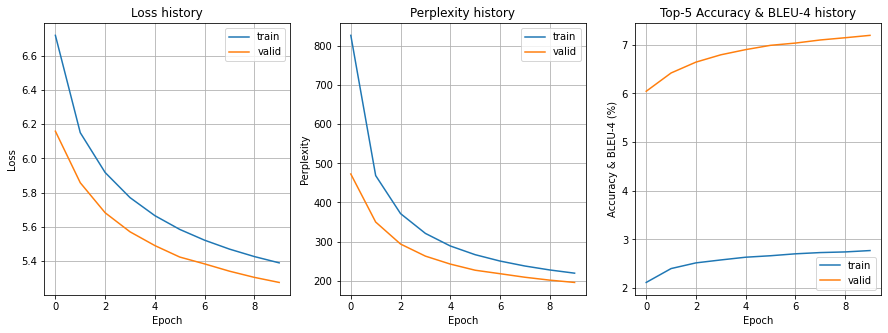

In [28]:
_, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history['ppl'], label='train')
axes[1].plot(history['val_ppl'], label='valid')
axes[1].set_title('Perplexity history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Perplexity')
axes[1].grid(True)
axes[1].legend()

axes[2].plot(history['acc'], label='train')
axes[2].plot(history['val_acc'], label='valid')
axes[2].set_title('Top-5 Accuracy & BLEU-4 history')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy & BLEU-4 (%)')
axes[2].grid(True)
axes[2].legend()

plt.show()

In [29]:
transformer.load_state_dict(torch.load('./models/transformer.pth'))
transformer.to(DEVICE)

Transformer(
  (encoder): EncoderLayer(
    (dropout): Dropout(p=0.25, inplace=False)
    (token_embedding): Embedding(18138, 32)
    (position_encoding): PositionalEncodingLayer()
    (encoder_block_layers): ModuleList(
      (0): EncoderBlockLayer(
        (dropout): Dropout(p=0.25, inplace=False)
        (multi_head_attention_layer): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=32, out_features=32, bias=True)
          (fc_k): Linear(in_features=32, out_features=32, bias=True)
          (fc_v): Linear(in_features=32, out_features=32, bias=True)
          (fc_o): Linear(in_features=32, out_features=32, bias=True)
        )
        (multi_head_attention_layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (position_wise_feed_forward_layer): PositionWiseFeedForwardLayer(
          (fc_in): Linear(in_features=32, out_features=64, bias=True)
          (fc_ou): Linear(in_features=64, out_features=32, bias=True)
        )
        (position_wise_feed_fo

In [ ]:
def find_path(tree):
    path = []
    for nodes in reversed(tree):
        if len(path) == 0:
            path.append(nodes[0])
        else:
            parent_id = path[-1].parent_id
            for node in nodes:
                if node.id == parent_id:
                    path.append(node)
    return path

def find_best_path(tree):
    best = []
    for nodes in reversed(tree):
        if len(best) == 0:
            best.append(nodes[0])
        else:
            nodes_eos = []
            parent_id = best[-1].parent_id
            for node in nodes:
                if node.eos:
                    nodes_eos.append(node)
                if node.id == parent_id:
                    best.append(node)
            if len(nodes_eos) > 0:
                candidates = sorted([best[-1], *nodes_eos],
                                    key=lambda node: node.logps,
                                    reverse=True)
                candidate = candidates[0]
                if candidate.eos:
                    best = [candidate]
    return best

class Node:
    id = 0
    
    def __init__(self, token, states, logp=0., parent=None, eos=False):
        self.id = self.__class__.id_
        self.token = token
        self.states = states
        self.logp = logp
        self.parent_id = None if parent is None else parent.id
        self.eos = eos
        self.level = 0 if parent is None else parent.level + 1
        self.logps = logp if parent is None else parent.logps + logp
        self.__class__.id_ += 1
        
    def __str__(self):
        return f'Node[id={self.__id}, ' + \
                    f'index={EN.vocab.itos[self.__token.cpu().item()]}, ' + \
                    f'logp={self.__logp}, ' + \
                    f'logps={self.__logps}, ' + \
                    f'parent_id={self.__parent_id}, ' + \
                    f'level={self.__level}]'

In [48]:
def evaluate(model, data, beam_size, src_field, dest_field, max_len, device):
    src_sentences = [*map(lambda example: example.src, data.examples)]
    dest_sentences = [*map(lambda example: example.trg, data.examples)]
    data = [*zip([*map(lambda word_list: src_field.process([word_list]), src_sentences)],
                 [*map(lambda word_list: dest_field.process([word_list]), dest_sentences)])]
    references, hypotheses, sources = [], [], []
    model.eval()
    with torch.no_grad():
        for i, (src_sequence, dest_sequence) in tqdm.tqdm(enumerate(data[:1000]), total=1000, position=0, leave=True):
            src_sequence, dest_sequence = src_sequence.to(device), dest_sequence.to(device)
            src_mask = model.make_src_mask(src_sequence)
            src_encoded = model.encoder(src_sequences=src_sequence, src_mask=src_mask)
            # Decoding
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=None)]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    # Get tokens that're already translated
                    already_translated = torch.LongTensor([*map(lambda node: node.token, find_path(tree))][::-1]).unsqueeze(0).to(device)
                    dest_mask = model.make_dest_mask(already_translated)
                    logit, _ = model.decoder(dest_sequences=already_translated, src_encoded=src_encoded,
                                              dest_mask=dest_mask, src_mask=src_mask) # [1, dest_seq_len, vocab_size]                    
                    logp = F.log_softmax(logit[:, -1, :], dim=1).squeeze(dim=0) # [vocab_size] Get scores                    
                    topk_logps, topk_tokens = torch.topk(logp, beam_size) # Get top k tokens & logps                    
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=None,
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True) # Sort next_nodes to get the best
                tree.append(next_nodes[:beam_size]) # Update the tree
            best_path = find_best_path(tree) # Find the best path of the tree

            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [dest_field.init_token, dest_field.eos_token], pred_translated[::-1])]

            hypotheses.append(pred_translated) # Update hypotheses

            # Update references
            references.append([[dest_field.vocab.itos[indice] for indice in dest_sequence[0] if indice not in (
                dest_field.vocab.stoi[dest_field.init_token],
                dest_field.vocab.stoi[dest_field.eos_token],
                dest_field.vocab.stoi[dest_field.pad_token]
            )]])

            # Update sources
            sources.append([src_field.vocab.itos[indice]  for indice in src_sequence[0] if indice not in (
                src_field.vocab.stoi[src_field.init_token],
                src_field.vocab.stoi[src_field.eos_token],
                src_field.vocab.stoi[src_field.pad_token]
            )])
    
        assert len(hypotheses) == len(references) == len(sources)
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25]) # Calculate BLEU-4 score
    return hypotheses, references, sources, bleu4

In [49]:
bleu_scores = []
for beam_size in [1, 3]:
    for name, data in [('validation', valid_data), ('test', test_data)]:
        _, _, _, bleu4 = evaluate(model=transformer, data=data, beam_size=beam_size, src_field=EN_TEXT, dest_field=RU_TEXT, max_len=MAX_LEN, device=DEVICE)
        bleu_scores.append((beam_size, name, bleu4))
        
for score in bleu_scores:
    print(f'BLEU-4: {score[2]*100:.3f}% with beam_size={score[0]} on {score[1]} data')

100%|██████████| 1000/1000 [07:47<00:00,  2.14it/s]


BLEU-4: 1.276% with beam_size=1 on validation data
BLEU-4: 1.258% with beam_size=1 on test data
BLEU-4: 1.276% with beam_size=3 on validation data
BLEU-4: 1.258% with beam_size=3 on test data


## Inference

In [55]:
def translate(sentences, model, beam_size, src_field, dest_field, max_len, device):
    if isinstance(sentences, list):
        sentences = [*map(src_field.preprocess, sentences)]
        targets = None
    if isinstance(sentences, Dataset):
        targets = [*map(lambda example: ' '.join(example.trg), sentences.examples)]
        sentences = [*map(lambda example: example.src, sentences.examples)]
    data = [*map(lambda word_list: src_field.process([word_list]), sentences)]
    translated_sentences, attention_weights, pred_logps = [], [], []
    model.eval()
    with torch.no_grad():
        for i, src_sequence in tqdm.tqdm(enumerate(data[:1000]), total=1000, position=0, leave=True):
            src_sequence = src_sequence.to(device)
            src_mask = model.make_src_mask(src_sequence)
            src_encoded = model.encoder(src_sequences=src_sequence, src_mask=src_mask)
            tree = [[Node(token=torch.LongTensor([dest_field.vocab.stoi[dest_field.init_token]]).to(device), states=())]]
            for _ in range(max_len):
                next_nodes = []
                for node in tree[-1]:
                    if node.eos: # Skip eos token
                        continue
                    # Get tokens that're already translated
                    already_translated = torch.LongTensor([*map(lambda node: node.token, find_path(tree))][::-1]).unsqueeze(0).to(device)
                    dest_mask = model.make_dest_mask(already_translated)
                    logit, attn_weights = model.decoder(dest_sequences=already_translated, src_encoded=src_encoded,
                                              dest_mask=dest_mask, src_mask=src_mask) # [1, dest_seq_len, vocab_size]                      
                    logp = F.log_softmax(logit[:, -1, :], dim=1).squeeze(dim=0) # [vocab_size] Get scores                    
                    topk_logps, topk_tokens = torch.topk(logp, beam_size) # Get top k tokens & logps                    
                    for k in range(beam_size):
                        next_nodes.append(Node(token=topk_tokens[k, None], states=(attn_weights,),
                                               logp=topk_logps[k, None].cpu().item(), parent=node,
                                               eos=topk_tokens[k].cpu().item() == dest_field.vocab[dest_field.eos_token]))
                if len(next_nodes) == 0:
                    break
                next_nodes = sorted(next_nodes, key=lambda node: node.logps, reverse=True)
                tree.append(next_nodes[:beam_size])
            best_path = find_best_path(tree)[::-1]
            # Get the translation
            pred_translated = [*map(lambda node: dest_field.vocab.itos[node.token], best_path)]
            pred_translated = [*filter(lambda word: word not in [
                dest_field.init_token, dest_field.eos_token
            ], pred_translated)]
            translated_sentences.append(' '.join(pred_translated))
            # Get probabilities
            pred_logps.append(sum([*map(lambda node: node.logps, best_path)]))
            # Get attention weights
            attention_weights.append(best_path[-1].states[0].cpu().numpy())
        sentences = [*map(lambda sentence: ' '.join(sentence), sentences)]
    return sentences, translated_sentences, targets, attention_weights, pred_logps

In [56]:
sentences, translated_sentences, dest_sentences, attention_weights, pred_logps = translate(sentences=test_data, model=transformer, beam_size=1, src_field=EN_TEXT,
                                                                                           dest_field=RU_TEXT, max_len=MAX_LEN, device=DEVICE)

100%|██████████| 1000/1000 [02:32<00:00,  6.55it/s]


In [62]:
indexes = np.random.choice(1000, size=10, replace=False)

for i in indexes:
    text = f'Source: {sentences[i]}\n'
    text += f'Ground truth translation: {dest_sentences[i]}\n'
    text += f'Predicted translation: {translated_sentences[i]}\n'
    print(text)
    print()

Source: to overcome the challenges we face and fulfill our promise to our children , we need active support from the international community .
Ground truth translation: для нетаньяху , подстрекательство является мощным политическим инструментом .
Predicted translation: в то время как <unk> <unk> , <unk> <unk> <unk> , <unk> , <unk> , <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> .


Source: it was gilani who sat next to singh to watch the game ; but , ultimately , process , rather than protocol , will determine how bilateral relations move forward .
Ground truth translation: именно гилани сел рядом с сингхом , чтобы посмотреть матч . но , в конечном счете , процесс , а не протокол , определит дальнейшее направление развития двухсторонних отношений .
Predicted translation: в то время как <unk> <unk> , <unk> <unk> <unk> , <unk> , <unk> , <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <

## P.S: 
The model is still being developed and improved. Seems like we need to fix some bugs or improve the model because it doesn't translate well.